# Librerías usadas

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

El fichero contiene archivos data_batch_1, .... data_batch_5 y test_batch. Estos archivos son objetos pickled que serán extraido con la función unpickle(extraida de la fuente:https://www.cs.toronto.edu/~kriz/cifar.html . 

# Funciones de la data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def extraer_data():
    # String del directorio(carpeta) y los director dentro de la carpeta
    DIR = 'cifar-10-batches-py/'
    dname= ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
    data=[]
    for d in dname:
        data.append(unpickle(DIR+d))
    return data

def one_hot(data,n):
    sess = tf.Session()
    one_hot= tf.one_hot(np.hstack([d[b'labels'] for d in data]),n)# n Num clases
    data_labels =sess.run(one_hot)
    sess.close()
    return data_labels

def resize_data(data):
    data=np.vstack([d[b'data'] for d in data])#data[b'data']
    len_data=len(data)
    data=data.reshape(len_data,3,32,32).transpose(0,2,3,1)/255
    print(type(data))
    return data

    

class Cifar():
    
    def __init__(self):
        self.i = 0
        self.nclass=10
        self.shuffle_array=np.random.permutation(50000)
        self.train_batch = [batch1,batch2,batch3,batch4,batch5]
        self.test_batch = [test_batch]
        self.training_images = None
        self.training_labels = None
        self.test_images = None
        self.test_labels = None
        
    def set_up_images(self):
        self.training_images=resize_data(self.train_batch)
        self.training_labels=one_hot(self.train_batch,self.nclass)
        self.test_images=resize_data(self.test_batch)
        self.test_labels=one_hot(self.test_batch,self.nclass)        

        
    def next_batch(self, batch_size,shuffle):
        if shuffle:
            x = self.training_images[self.shuffle_array[self.i:self.i+batch_size]].reshape(batch_size,32,32,3)
            y = self.training_labels[self.shuffle_array[self.i:self.i+batch_size]]
        else:
            x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,32,32,3)
            y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

# Funciones de la red neuronal convolucional

In [3]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def training(init,TrainByOptimizer,epochs,batch_size,shuffle,model_name):
    import time
    saver = tf.train.Saver()
    precision=np.array([]);
    cost_history = np.array([],dtype='float32');
    jump=100
    x1=np.array(range(0,epochs,jump))
    Ti= time.time()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess:
        sess.run(init)
        for i in range(epochs):
            batch = c.next_batch(batch_size,shuffle)
            sess.run(TrainByOptimizer, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
            cost_history = np.append(cost_history,sess.run(cost_function,feed_dict={x: batch[0],y_true: batch[1],hold_prob: 0.5}))
            if i%jump == 0:   
                matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
                acc = tf.reduce_mean(tf.cast(matches,tf.float32))
                a=sess.run(acc,feed_dict={x:c.test_images,y_true:c.test_labels,hold_prob:1.0})
                precision=np.append(precision,a)
        save_path = saver.save(sess, "/home/visoc/Documentos/Modelos/"+model_name)
    Tf= time.time()
    T=Tf-Ti
    return (np.array([precision,cost_history,T]))

In [4]:
def drawnPrecision(result,name,color):
    precision=result[0]
    plt.plot(range(len(precision)),precision,label='Optimizador '+name,color=color)
    plt.xlabel('iteracion (x10^2)')
    plt.ylabel('precision')
    plt.title('Optimizador '+name)         

In [5]:
def drawnCost(result,name,color):
    cost=result[1]
    plt.plot(range(len(cost)),cost,label='Optimizador '+name,color=color)
    plt.xlabel('iteracion')
    plt.ylabel('Error')
    plt.title('Optimizador '+name)

In [6]:
def result(r,name,epochs):
    np.save('/home/visoc/Documentos/Modelos/'+name+str(epochs), r)
    precision=r[0]
    cost=r[1]
    time=r[2]
    print('precision= '+str(precision[len(precision)-1]))
    print('error= '+str(cost[len(cost)-1]))
    print('time= '+str(time)) 
    

<class 'numpy.ndarray'>


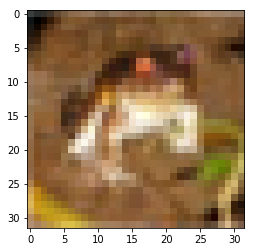

In [7]:
datos=extraer_data()
batch_meta,batch1,batch2,batch3,batch4,batch5,test_batch=datos
#batch1[b'data']
X=resize_data([batch1]) #
#X=batch1[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")#transforma la data
plt.imshow(X[0])#muestra de la data

In [8]:
c = Cifar()
c.set_up_images()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3],name='x')
y_true = tf.placeholder(tf.float32,shape=[None,10],name='y_true')
y_pred = tf.placeholder(tf.float32,shape=[None,10],name='y_pred')
hold_prob = tf.placeholder(tf.float32)

In [12]:
convo1 = convolutional_layer(x,shape=[4,4,3,32])
pooling1 = max_pool_2by2(convo1)
convo2 = convolutional_layer(pooling1,shape=[4,4,32,64])
pooling2 = max_pool_2by2(convo2)
flatting = tf.reshape(pooling2,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(flatting,1024))
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,10)
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

# Optimizadores a usar

In [13]:
Momentum=tf.train.MomentumOptimizer(learning_rate=0.001,momentum=0.9)
Nesterov=tf.train.MomentumOptimizer(learning_rate=0.001,momentum=0.9,use_nesterov=True)
AdaGrad=tf.train.AdagradOptimizer(learning_rate=0.001,initial_accumulator_value=0.1)
RMS=tf.train.RMSPropOptimizer(learning_rate=0.001)
Adam = tf.train.AdamOptimizer(learning_rate=0.001)

In [14]:
TrainByMomentum=Momentum.minimize(cost_function)
TrainByNesterov=Nesterov.minimize(cost_function)
TrainByAdaGrad=AdaGrad.minimize(cost_function)
TrainByRMS=RMS.minimize(cost_function)
TrainByAdam = Adam.minimize(cost_function)

In [15]:
init = tf.global_variables_initializer()

In [16]:
epochs=10000
batch_size=100
shuffle=True

In [17]:
Mresult=training(init,TrainByMomentum,epochs,batch_size,shuffle,"momentum")

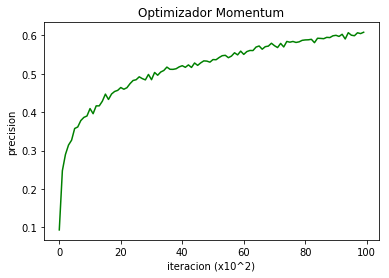

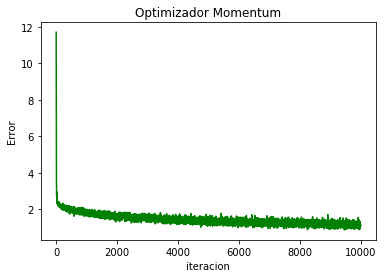

precision= 0.6080999970436096
error= 1.1046042
time= 585.4135150909424


In [18]:
drawnPrecision(Mresult,name='Momentum',color='green')
plt.show()
drawnCost(Mresult,name='Momentum',color='green')
plt.show()
result(Mresult,'Momentum',epochs)

In [19]:
Nresult=training(init,TrainByNesterov,epochs,batch_size,shuffle,"Nesterov")

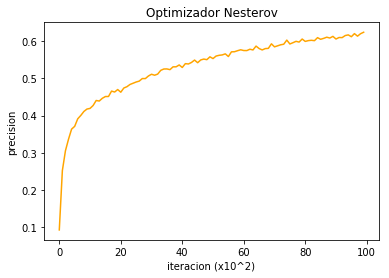

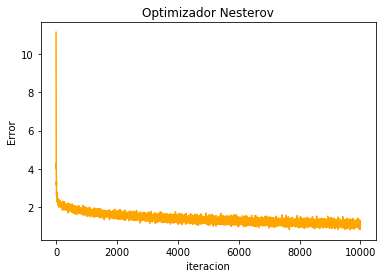

precision= 0.6237000226974487
error= 1.0832423
time= 605.1992712020874


In [20]:
drawnPrecision(Nresult,name='Nesterov',color='orange')
plt.show()
drawnCost(Nresult,name='Nesterov',color='orange')
plt.show()
result(Nresult,'Nesterov',epochs)

In [21]:
Aresult=training(init,TrainByAdaGrad,epochs,batch_size,shuffle,"Adagrad")

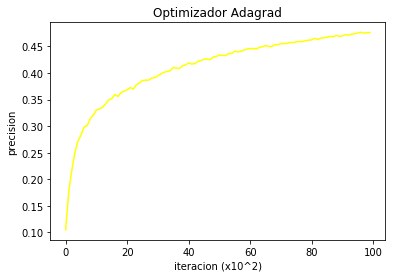

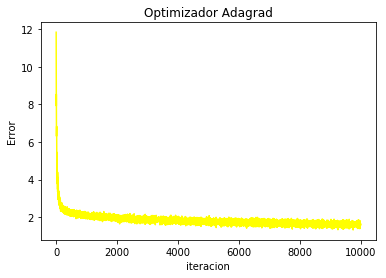

precision= 0.47620001435279846
error= 1.6405264
time= 598.5480625629425


In [22]:
drawnPrecision(Aresult,name='Adagrad',color='yellow')
plt.show()
drawnCost(Aresult,name='Adagrad',color='yellow')
plt.show()
result(Aresult,'Adagrad',epochs)

In [23]:
Rresult=training(init,TrainByRMS,epochs,batch_size,shuffle,"RMS")

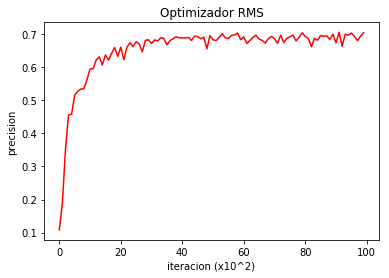

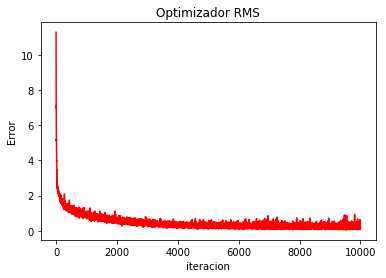

precision= 0.7031000256538391
error= 0.19267195
time= 621.1794695854187


In [24]:
drawnPrecision(Rresult,name='RMS',color='red')
plt.show()
drawnCost(Rresult,name='RMS',color='red')
plt.show()
result(Rresult,'RMS',epochs)

In [25]:
Adamresult=training(init,TrainByAdam,epochs,batch_size,shuffle,"ADAM")

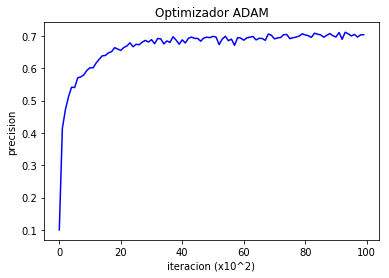

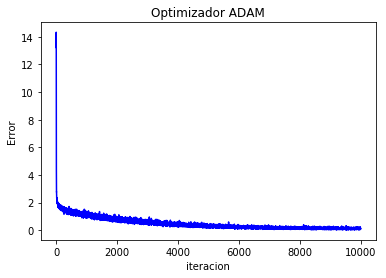

precision= 0.704200029373169
error= 0.14039764
time= 622.1894750595093


In [26]:
drawnPrecision(Adamresult,name='ADAM',color='blue')
plt.show()
drawnCost(Adamresult,name='ADAM',color='blue')
plt.show()
result(Adamresult,'ADAM',epochs)

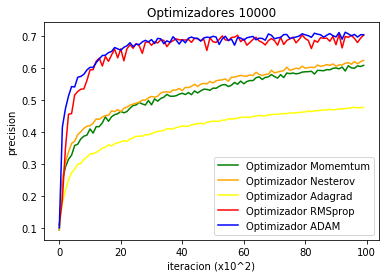

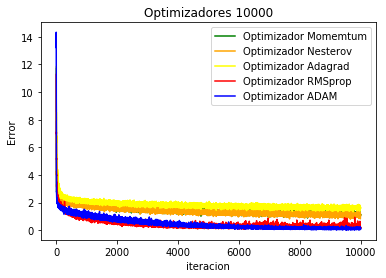

In [27]:
drawnPrecision(Mresult,name='Momemtum',color='green')
drawnPrecision(Nresult,name='Nesterov',color='orange')
drawnPrecision(Aresult,name='Adagrad',color='yellow')
drawnPrecision(Rresult,name='RMSprop',color='red')
drawnPrecision(Adamresult,name='ADAM',color='blue')
plt.legend()
plt.title('Optimizadores '+str(epochs))
plt.show()
drawnCost(Mresult,name='Momemtum',color='green')
drawnCost(Nresult,name='Nesterov',color='orange')
drawnCost(Aresult,name='Adagrad',color='yellow')
drawnCost(Rresult,name='RMSprop',color='red')
drawnCost(Adamresult,name='ADAM',color='blue')
plt.title('Optimizadores '+ str(epochs))
plt.legend()
plt.show()

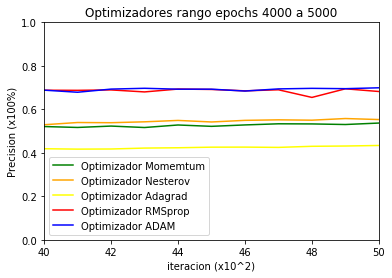

In [29]:
drawnPrecision(Mresult,name='Momemtum',color='green')
drawnPrecision(Nresult,name='Nesterov',color='orange')
drawnPrecision(Aresult,name='Adagrad',color='yellow')
drawnPrecision(Rresult,name='RMSprop',color='red')
drawnPrecision(Adamresult,name='ADAM',color='blue')
plt.legend()
plt.ylabel('Precision (x100%)')
plt.xlabel('iteracion (x10^2)')
plt.title('Optimizadores rango epochs 9000 a 10000')
plt.axis([90,100,0,1])
plt.show()